# CLT Project - Stage III





- **Author:**             Arian Contessotto, Tim Giger, Levin Reichmuth
- **Submission Date:**    1 June 2023

## 1. Prerequisites and Load

In [1]:
# Set connection to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


If necessary, install the required packages.

In [ ]:
# Required package installation
!pip install transformers
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 1.1 Import Packages and Make Downloads

In [ ]:
# Import general packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
#from sklearn.metrics import precision_score, recall_score, accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

### 1.2 Load Data

The final dataframe from stage one is loaded. These data are the basis for stage two.

In [ ]:
# Define file name
esg_file = '/content/drive/MyDrive/Colab_Notebooks/CLT_Project_HSLU_Stage3/full_llm_annotated.csv'

# Define function to load and merge data
def load_data(file):

    # Load the data
    df = pd.read_csv(file, delimiter = '|')

    # Apply eval function
    df['esg_topics'] = df['esg_topics'].apply(eval)
    df['sentence_tokens'] = df['sentence_tokens'].apply(eval)
    df['sentiment_llm_continuous'] = df['sentiment_llm_continuous'].apply(eval)
    df['sentiment_llm_categorial'] = df['sentiment_llm_categorial'].apply(eval)

    return df

# Load and merge the data
df = load_data(esg_file)

# Print shape and diyplay header
print(df.shape)
df.head()

(11071, 17)


,company,datatype,title,date,domain,esg_topics,internal,symbol,sentence_tokens,market_cap_in_usd_b,sector,industry,year_month,year,month,sentiment_llm_continuous,sentiment_llm_categorial
0,Beiersdorf,sustainability_report,BeiersdorfAG Sustainability Report 2021,2021-03-31,NaN,"[CleanWater, GHGEmission, ProductLiability, Va...",1,BEI,[brands strategy sustainability agenda care be...,25.99,Consumer Staples,Household & Personal Products,2021-03,2021,3,"[0.4510161280632019, 0.6138720512390137, 0.226...","[0.5, 0.5, 0.0, 0.0, 0.5, 0.5, 0.5, 0.5, 1.0, ..."
1,Deutsche Telekom,sustainability_report,DeutscheTelekomAG Sustainability Report 2021,2021-03-31,NaN,"[DataSecurity, Iso50001, GlobalWarming, Produc...",1,DTE,"[management facts, deutsche telekom cr report,...",101.78,Communication Services,Telecom Services,2021-03,2021,3,"[0.35756340622901917, 0.29088783264160156, 0.3...","[0.5, 0.0, 0.5, 0.5, 0.0, 0.5, 0.5, 0.5, 0.5, ..."
2,Vonovia,sustainability_report,VonoviaSE Sustainability Report 2021,2021-03-31,NaN,"[Whistleblowing, DataSecurity, Vaccine, GHGEmi...",1,VNA,"[sustainable future, sustainability report dea...",20.35,Real Estate,Real Estate Services,2021-03,2021,3,"[0.4570336639881134, 0.45287153124809265, 0.26...","[0.5, 0.5, 0.0, 0.5, 0.5, 0.5, 0.0, 0.5, 0.0, ..."
3,Merck,sustainability_report,MerckKGaA Sustainability Report 2021,2021-03-31,NaN,"[DataSecurity, DataMisuse, DrugResistance, Iso...",1,MRK,[management employees profile attractive emplo...,87.64,Healthcare,Drug Manufacturers—Specialty & Generic,2021-03,2021,3,"[0.36378589272499084, 0.6118267178535461, 0.48...","[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ..."
4,MTU,sustainability_report,MTUAeroEngines Sustainability Report 2020,2020-03-31,NaN,"[WorkLifeBalance, Corruption, AirQuality, Data...",1,MTX,[sustainability goes far beyond climate action...,12.24,Industrials,Aerospace & Defense,2020-03,2020,3,"[0.46082836389541626, 0.46208637952804565, 0.4...","[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.0, 0.5, 0.5, ..."


In [ ]:
# Function to create Subset to test code
def create_subset(df):
    # Select 5 rows with internal value of 1
    subset_1 = df[df['internal'] == 1].head(3)

    # Select 10 rows with internal value of 0
    subset_0 = df[df['internal'] == 0].head(10)

    # Concatenate the two subsets
    subset = pd.concat([subset_1, subset_0])

    # Reset the index of the subset
    subset = subset.reset_index(drop=True)

    return subset

# Create subset
subset_df = create_subset(df)


In [ ]:
# Function to create sentence data
def create_sentence_df(data):
  
  # Get sentences and sentiments from data
  sentence_lists = data['sentence_tokens'].tolist()
  sentences = [sentence for sublist in sentence_lists for sentence in sublist]
  sentiment_list = data['sentiment_llm_categorial'].tolist()
  sentiment = [sentiment for sublist in sentiment_list for sentiment in sublist]

  # Create pandas dataframe
  df = {'sentence': sentences, 'sentiment': sentiment}
  sentence_df = pd.DataFrame(df)

  # Compute length of sentences
  sentence_df['sentence_length'] = sentence_df['sentence'].apply(lambda x: len(x.split())) 

  return sentence_df

# Create sentence data
sentence_df = create_sentence_df(subset_df)

# Display header
sentence_df.head()

,sentence,sentiment,sentence_length
0,brands strategy sustainability agenda care bey...,0.5,105
1,successfully reduced carbon footprint absolute...,0.5,11
2,end consumer business returned levels reduced ...,0.0,17
3,decoupling human economic activity natural res...,0.0,14
4,inspired beiersdorf ambitious sustainability a...,0.5,13


In [ ]:
sentence_df['sentence_length'].max()

382

## Train, Dev, Test Split

In [ ]:
# Split the DataFrame into train, dev, and test sets
train_df, temp_df = train_test_split(sentence_df, test_size=0.3, random_state=42)
dev_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

## Tokenize Sentences

In [ ]:
# Define the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Tokenize the sentences and convert them to input features
def tokenize_sentences(sentences):
    input_ids = []
    attention_masks = []
    
    for sentence in sentences:
        encoded_dict = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=100,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)

# Tokenize the sentences in the train, dev, and test sets
train_sentences = train_df['sentence'].tolist()
dev_sentences = dev_df['sentence'].tolist()
test_sentences = test_df['sentence'].tolist()
train_inputs, train_masks = tokenize_sentences(train_sentences)
dev_inputs, dev_masks = tokenize_sentences(dev_sentences)
test_inputs, test_masks = tokenize_sentences(test_sentences)

## Convert sentiment scores to tensors

In [ ]:
# Convert the sentiment scores to tensors
train_labels = torch.tensor(train_df['sentiment'].tolist())
dev_labels = torch.tensor(dev_df['sentiment'].tolist())
test_labels = torch.tensor(test_df['sentiment'].tolist())

## Create DataLoader and Load Data

In [ ]:
# Create a DataLoader for each set
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

dev_data = TensorDataset(dev_inputs, dev_masks, dev_labels)
dev_sampler = SequentialSampler(dev_data)
dev_dataloader = DataLoader(dev_data, sampler=dev_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

## Train base model

In [ ]:
# Load the pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)

# Set the device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.to(device)

# Set the optimizer and parameter
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 1
batch_size = 16

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

cuda


In [ ]:
for epoch in range(num_epochs):
    model.train()
    
    for batch in train_dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs, masks, labels = batch
        
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

# After training
trained_model = model

In [ ]:
print(trained_model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## Evaluate base model on dev set

In [ ]:
# Evaluation on the dev set
trained_model.eval()
dev_predictions = []

with torch.no_grad():
    for batch in dev_dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs, masks, labels = batch

        outputs = trained_model(inputs, attention_mask=masks)
        logits = outputs.logits

        predictions = torch.sigmoid(logits).squeeze().tolist()
        dev_predictions.extend(predictions)

    # Handle the remaining instances
    if len(dev_predictions) < len(dev_labels):
        remaining_instances = len(dev_labels) - len(dev_predictions)
        last_batch_inputs = dev_inputs[-remaining_instances:]
        last_batch_masks = dev_masks[-remaining_instances:]
        last_batch = (last_batch_inputs, last_batch_masks)

        last_batch = tuple(t.to(device) for t in last_batch)

        outputs = trained_model(*last_batch, attention_mask=last_batch[1])
        logits = outputs.logits

        predictions = torch.sigmoid(logits).squeeze().tolist()
        dev_predictions.extend(predictions)

# Calculate evaluation metrics
# Define the thresholds for discretization
thresholds = [1/3, 2/3]

# Discretize the predicted probabilities
discretized_predictions = np.digitize(dev_predictions, thresholds)

# Convert continuous labels to integers
dev_labels_int = np.digitize(dev_labels, thresholds)

# Create the confusion matrix-like representation
num_classes = len(thresholds) + 1  # Number of classes: below threshold, between thresholds, above threshold
cm = np.zeros((num_classes, num_classes))

for true_label, predicted_label in zip(dev_labels_int, discretized_predictions):
    cm[true_label, predicted_label] += 1

# Print the confusion matrix-like representation
print("Confusion Matrix:")
print(cm)

# Get the values from the confusion matrix
TP = cm[1, 1]
FP = cm[0, 1] + cm[2, 1]
FN = cm[1, 0] + cm[1, 2]
TN = cm[0, 0] + cm[0, 2] + cm[2, 0] + cm[2, 2]

# Compute accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Compute precision
precision = TP / (TP + FP)

# Compute recall
recall = TP / (TP + FN)

# Print the metrics
print(f"Accuracy:", accuracy)
print(f"Precision:", precision)
print(f"Recall:", recall)

Confusion Matrix:
[[  0. 292.   0.]
 [  0. 791.   0.]
 [  0.  29.   0.]]
Accuracy: 0.7113309352517986
Precision: 0.7113309352517986
Recall: 1.0


## Parameter tuning

In [ ]:
# Define list of parameters
batch_sizes = [16]
learning_rates = [5e-5, 1e-5]
num_epochs_list = [1, 2]

# Set results dict
results = {
    'batch_size': [],
    'learning_rate': [],
    'num_epochs': [],
    'accuracy': [],
    'precision': [],
    'recall': [],
    'confusion_matrix': []
}

# Iterate over parameter combinations
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        for num_epochs in num_epochs_list:
            # Train the model with the current hyperparameters
           
            # Load the pre-trained BERT model for sequence classification
            model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)

            # Set the device (GPU if available, else CPU)
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            print(device)
            model = model.to(device)

            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
            train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

            for epoch in range(num_epochs):
                model.train()
                for batch in train_dataloader:
                    batch = tuple(t.to(device) for t in batch)
                    inputs, masks, labels = batch
                    
                    optimizer.zero_grad()
                    # Forward pass
                    outputs = model(inputs, attention_mask=masks, labels=labels)
                    loss = outputs.loss
                    logits = outputs.logits
                    
                    # Backward pass and optimization
                    loss.backward()
                    optimizer.step()

            # Evaluation on dev set
            model.eval()
            dev_predictions = []

            with torch.no_grad():
                for batch in dev_dataloader:
                    batch = tuple(t.to(device) for t in batch)
                    inputs, masks, labels = batch

                    outputs = trained_model(inputs, attention_mask=masks)
                    logits = outputs.logits

                    predictions = torch.sigmoid(logits).squeeze().tolist()
                    dev_predictions.extend(predictions)

                # Handle the remaining instances
                if len(dev_predictions) < len(dev_labels):
                    remaining_instances = len(dev_labels) - len(dev_predictions)
                    last_batch_inputs = dev_inputs[-remaining_instances:]
                    last_batch_masks = dev_masks[-remaining_instances:]
                    last_batch = (last_batch_inputs, last_batch_masks)

                    last_batch = tuple(t.to(device) for t in last_batch)

                    outputs = trained_model(*last_batch, attention_mask=last_batch[1])
                    logits = outputs.logits

                    predictions = torch.sigmoid(logits).squeeze().tolist()
                    dev_predictions.extend(predictions)

            # Calculate evaluation metrics
            # Define the thresholds for discretization
            thresholds = [1/3, 2/3]

            # Discretize the predicted probabilities
            discretized_predictions = np.digitize(dev_predictions, thresholds)

            # Convert continuous labels to integers
            dev_labels_int = np.digitize(dev_labels, thresholds)

            # Create the confusion matrix-like representation
            num_classes = len(thresholds) + 1  # Number of classes: below threshold, between thresholds, above threshold
            cm = np.zeros((num_classes, num_classes))

            for true_label, predicted_label in zip(dev_labels_int, discretized_predictions):
                cm[true_label, predicted_label] += 1

            # Print the confusion matrix-like representation
            print("Confusion Matrix:")
            print(cm)

            # Get the values from the confusion matrix
            TP = cm[1, 1]
            FP = cm[0, 1] + cm[2, 1]
            FN = cm[1, 0] + cm[1, 2]
            TN = cm[0, 0] + cm[0, 2] + cm[2, 0] + cm[2, 2]

            # Compute accuracy
            accuracy = (TP + TN) / (TP + TN + FP + FN)

            # Compute precision
            precision = TP / (TP + FP)

            # Compute recall
            recall = TP / (TP + FN)

            # Store the results in the dictionary
            results['batch_size'].append(batch_size)
            results['learning_rate'].append(learning_rate)
            results['num_epochs'].append(num_epochs)
            results['accuracy'].append(accuracy)
            results['precision'].append(precision)
            results['recall'].append(recall)
            results['confusion_matrix'].append(cm)

# Create results df out of results dictionary
results_df = pd.DataFrame(results)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

cuda
Confusion Matrix:
[[  0. 292.   0.]
 [  0. 791.   0.]
 [  0.  29.   0.]]


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

cuda
Confusion Matrix:
[[  0. 292.   0.]
 [  0. 791.   0.]
 [  0.  29.   0.]]


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

cuda
Confusion Matrix:
[[  0. 292.   0.]
 [  0. 791.   0.]
 [  0.  29.   0.]]


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

cuda
Confusion Matrix:
[[  0. 292.   0.]
 [  0. 791.   0.]
 [  0.  29.   0.]]


In [ ]:
# Display results dataframe
results_df

,batch_size,learning_rate,num_epochs,accuracy,precision,recall,confusion_matrix
0,16,0.00005,1,0.711331,0.711331,1.0,"[[0.0, 292.0, 0.0], [0.0, 791.0, 0.0], [0.0, 2..."
1,16,0.00005,2,0.711331,0.711331,1.0,"[[0.0, 292.0, 0.0], [0.0, 791.0, 0.0], [0.0, 2..."
2,16,0.00001,1,0.711331,0.711331,1.0,"[[0.0, 292.0, 0.0], [0.0, 791.0, 0.0], [0.0, 2..."
3,16,0.00001,2,0.711331,0.711331,1.0,"[[0.0, 292.0, 0.0], [0.0, 791.0, 0.0], [0.0, 2..."


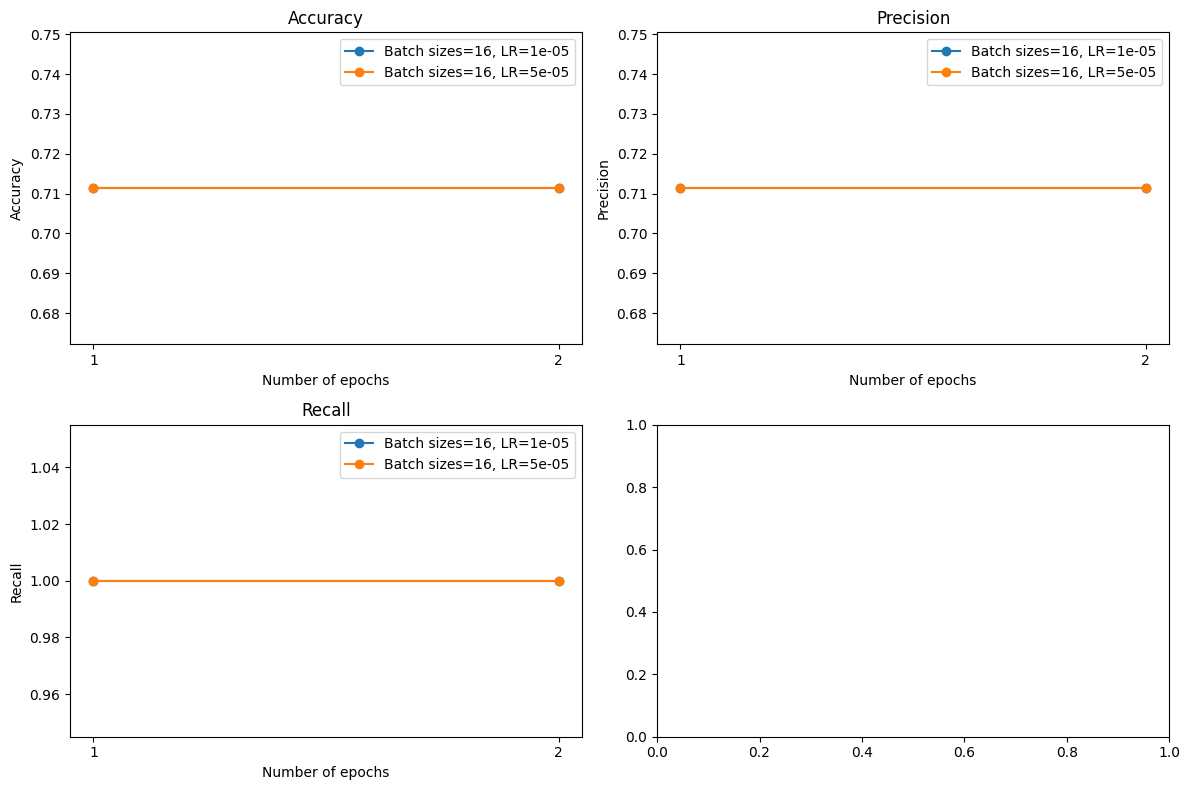

In [ ]:
# Create subplots for each metric
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
metrics = ['accuracy', 'precision', 'recall']
num_epochs = results_df['num_epochs'].unique().tolist()

for i, metric in enumerate(metrics):
    ax = axes[i // 2, i % 2]
    
    # Group the dataframe by batch_size and learning_rate
    grouped_df = results_df.groupby(['batch_size', 'learning_rate'])
    
    # Iterate over the unique combinations
    for (bs, lr), group in grouped_df:
        # Get the metric values for the current combination
        metric_values = group[metric].values
        
        # Plot the metric values as a line
        ax.plot(num_epochs, metric_values, marker='o', label=f"Batch sizes={bs}, LR={lr}")

    ax.set_xticks(num_epochs)
    ax.set_xticklabels(num_epochs)
    ax.set_xlabel("Number of epochs")
    ax.set_ylabel(metric.capitalize())
    ax.set_title(metric.capitalize())
    ax.legend()

plt.tight_layout()
plt.show()


## Train final model

In [ ]:
# Load the pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)

# Set the device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.to(device)

# Set the optimizer and parameter
optimizer = AdamW(model.parameters(), lr=1e-5)
num_epochs = 3
batch_size = 16

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

cuda


In [ ]:
train_loss_values = []  # List to store training loss values

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0  # Variable to accumulate the loss for each epoch
    
    for batch in train_dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs, masks, labels = batch
        
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()  # Accumulate the loss for the current batch
        
    # Calculate the average training loss for the epoch
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    
    train_loss_values.append(avg_epoch_loss)  # Store the training loss value for the epoch
    
    # Print the training loss for the epoch
    print(f"Epoch {epoch+1} - Training Loss: {avg_epoch_loss:.4f}")

# After training
final_model = model


Epoch 1 - Training Loss: 0.0641
Epoch 2 - Training Loss: 0.0494
Epoch 3 - Training Loss: 0.0394


In [ ]:
print(final_model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## Evaluate final model

In [ ]:
# Evaluation on the test set
final_model.eval()
test_predictions = []

with torch.no_grad():
    for batch in test_dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs, masks, labels = batch

        outputs = final_model(inputs, attention_mask=masks)
        logits = outputs.logits

        predictions = torch.sigmoid(logits).squeeze().tolist()
        test_predictions.extend(predictions)

    # Handle the remaining instances
    if len(test_predictions) < len(test_labels):
        remaining_instances = len(test_labels) - len(test_predictions)
        last_batch_inputs = test_inputs[-remaining_instances:]
        last_batch_masks = test_masks[-remaining_instances:]
        last_batch = (last_batch_inputs, last_batch_masks)

        last_batch = tuple(t.to(device) for t in last_batch)

        outputs = final_model(*last_batch, attention_mask=last_batch[1])
        logits = outputs.logits

        predictions = torch.sigmoid(logits).squeeze().tolist()
        test_predictions.extend(predictions)

# Calculate evaluation metrics
# Define the thresholds for discretization
thresholds = [1/3, 2/3]

# Discretize the predicted probabilities
discretized_predictions = np.digitize(test_predictions, thresholds)

# Convert continuous labels to integers
test_labels_int = np.digitize(test_labels, thresholds)

# Create the confusion matrix-like representation
num_classes = len(thresholds) + 1  # Number of classes: below threshold, between thresholds, above threshold
cm = np.zeros((num_classes, num_classes))

for true_label, predicted_label in zip(test_labels_int, discretized_predictions):
    cm[true_label, predicted_label] += 1

# Print the confusion matrix-like representation
print("Confusion Matrix:")
print(cm)

# Get the values from the confusion matrix
TP = cm[1, 1]
FP = cm[0, 1] + cm[2, 1]
FN = cm[1, 0] + cm[1, 2]
TN = cm[0, 0] + cm[0, 2] + cm[2, 0] + cm[2, 2]

# Compute accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Compute precision
precision = TP / (TP + FP)

# Compute recall
recall = TP / (TP + FN)

# Print the metrics
print(f"Accuracy:", accuracy)
print(f"Precision:", precision)
print(f"Recall:", recall)

Confusion Matrix:
[[  0. 308.   0.]
 [  0. 762.   7.]
 [  0.  23.  12.]]
Accuracy: 0.6960431654676259
Precision: 0.6971637694419031
Recall: 0.9908972691807543


## Annotate sentiments with final prediction model

In [ ]:
# Define the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Tokenize the sentences and convert them to input features
def tokenize_sentences(sentences):
    input_ids = []
    attention_masks = []
    
    for sentence in sentences:
        encoded_dict = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=100,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)

def make_predictions(tokenized_sentences):
  inputs, masks = tokenized_sentences

  # Prepare the data for model input
  inputs = inputs.to(device)
  masks = masks.to(device)

  # Evaluate the model on the dataframe
  final_model.eval()
  sentiment_predictions = []

  with torch.no_grad():
      for i in range(len(inputs)):
          input_ids = inputs[i].unsqueeze(0)
          attention_mask = masks[i].unsqueeze(0)
          
          outputs = final_model(input_ids, attention_mask=attention_mask)
          logits = outputs.logits
          
          predictions = torch.sigmoid(logits).squeeze().tolist()
          sentiment_predictions.append(predictions)
  return sentiment_predictions

subset_df['tokenized_sentences'] = subset_df['sentence_tokens'].apply(lambda x: tokenize_sentences(x))
subset_df['sentiments'] = subset_df['tokenized_sentences'].apply(lambda x: make_predictions(x))
subset_df.head()

,company,datatype,title,date,domain,esg_topics,internal,symbol,sentence_tokens,market_cap_in_usd_b,sector,industry,year_month,year,month,sentiment_llm_continuous,sentiment_llm_categorial,tokenized_sentences,sentiments
0,Beiersdorf,sustainability_report,BeiersdorfAG Sustainability Report 2021,2021-03-31,NaN,"[CleanWater, GHGEmission, ProductLiability, Va...",1,BEI,[brands strategy sustainability agenda care be...,25.99,Consumer Staples,Household & Personal Products,2021-03,2021,3,"[0.4510161280632019, 0.6138720512390137, 0.226...","[0.5, 0.5, 0.0, 0.0, 0.5, 0.5, 0.5, 0.5, 1.0, ...","([[tensor(101), tensor(9639), tensor(5656), te...","[0.6280699968338013, 0.635158121585846, 0.5237..."
1,Deutsche Telekom,sustainability_report,DeutscheTelekomAG Sustainability Report 2021,2021-03-31,NaN,"[DataSecurity, Iso50001, GlobalWarming, Produc...",1,DTE,"[management facts, deutsche telekom cr report,...",101.78,Communication Services,Telecom Services,2021-03,2021,3,"[0.35756340622901917, 0.29088783264160156, 0.3...","[0.5, 0.0, 0.5, 0.5, 0.0, 0.5, 0.5, 0.5, 0.5, ...","([[tensor(101), tensor(2968), tensor(8866), te...","[0.6260223388671875, 0.5378746390342712, 0.629..."
2,Vonovia,sustainability_report,VonoviaSE Sustainability Report 2021,2021-03-31,NaN,"[Whistleblowing, DataSecurity, Vaccine, GHGEmi...",1,VNA,"[sustainable future, sustainability report dea...",20.35,Real Estate,Real Estate Services,2021-03,2021,3,"[0.4570336639881134, 0.45287153124809265, 0.26...","[0.5, 0.5, 0.0, 0.5, 0.5, 0.5, 0.0, 0.5, 0.0, ...","([[tensor(101), tensor(9084), tensor(2925), te...","[0.6230962872505188, 0.6429548859596252, 0.503..."
3,Adidas,tech,"Desktop Metal acquires Adaptive3D, Q1 revenue ...",2021-05-17,zdnet,[Privacy],0,ADS,[latest acquisition gives rubber materials par...,25.77,Consumer Discretionary,Footwear & Accessories,2021-05,2021,5,"[0.6561538577079773, 0.4547191560268402, 0.436...","[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...","([[tensor(101), tensor(6745), tensor(7654), te...","[0.6344193816184998, 0.6288015842437744, 0.629..."
4,Adidas,general,Victoria Beckham Style: 42 Looks Anyone Can Copy,2022-02-19,whowhatwear,[GenderDiversity],0,ADS,"[style never underestimated, ordinarily likely...",25.77,Consumer Discretionary,Footwear & Accessories,2022-02,2022,2,"[0.24463315308094025, 0.3060062825679779, 0.69...","[0.0, 0.0, 1.0, 0.5, 0.0, 0.5, 0.5, 0.5, 0.5, ...","([[tensor(101), tensor(2806), tensor(2196), te...","[0.6389425992965698, 0.6030560731887817, 0.652..."


## Compare internal vs. external

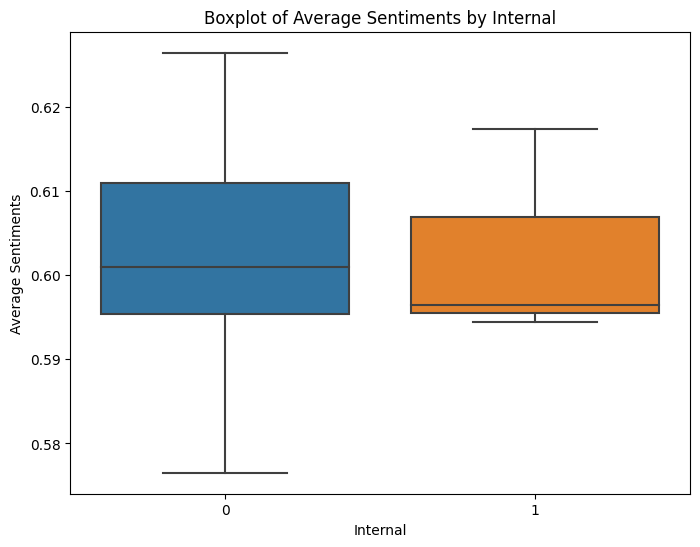

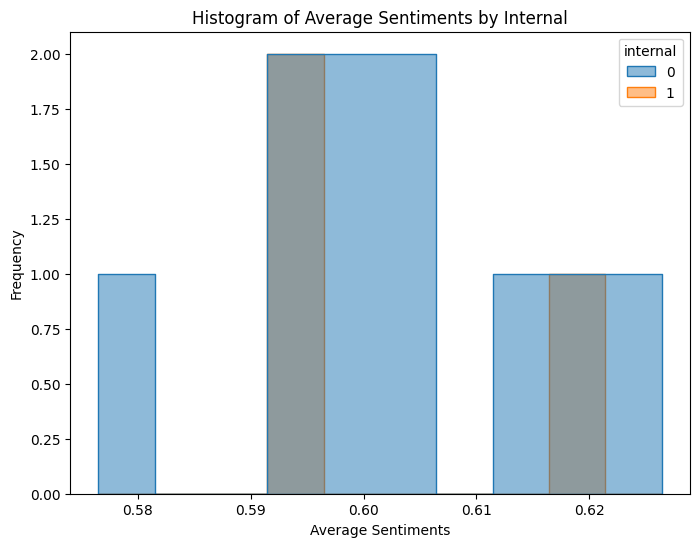

In [ ]:
# Compute the average of each list in the 'sentiments' column
subset_df['sentiments_avg'] = subset_df['sentiments'].apply(lambda x: np.mean(x))

# Create two separate dataframes for internal values 0 and 1
subset_internal_0 = subset_df[subset_df['internal'] == 0]
subset_internal_1 = subset_df[subset_df['internal'] == 1]

# Create boxplots for average sentiments grouped by internal values
plt.figure(figsize=(8, 6))
sns.boxplot(x='internal', y='sentiments_avg', data=subset_df)
plt.xlabel('Internal')
plt.ylabel('Average Sentiments')
plt.title('Boxplot of Average Sentiments by Internal')
plt.show()

# Create histograms for average sentiments grouped by internal values
plt.figure(figsize=(8, 6))
sns.histplot(data=subset_df, x='sentiments_avg', hue='internal', element='step', bins=10, alpha=0.5, legend=True)
plt.xlabel('Average Sentiments')
plt.ylabel('Frequency')
plt.title('Histogram of Average Sentiments by Internal')
plt.show()
